In [5]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import pyLDAvis
import pyLDAvis.sklearn
import re 

import winsound
import nltk

#nltk.download('punkt')
from nltk.stem import *
from nltk.corpus import stopwords
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation as LDA

from imblearn.metrics import classification_report_imbalanced
from imblearn.datasets import make_imbalance
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder

from psycopg2 import extras
from config.postgres_config import host, database
from security.postgres_security import user, password

In [6]:
#set a connection with database and pull query from sandbox
#this only works if vpn connection is established

def pull_data_from_postgres():
    try:
        with psycopg2.connect(user= user,
                                  password = password,
                                  host = host,
                                  database = database) as conn:
            df = pd.read_sql("""
                             SELECT DISTINCT
                                invoice_uom,
                                material_group_description,
                                material_description,
                                cost_center_text,
                                g_l_account_text,
                                cat_lvl_0_text,
                                cat_lvl_1_text,
                                cat_lvl_2_text,
                                cat_lvl_3_text,
                                cat_lvl_4_text,
                                cat_lvl_5_text
                                FROM sandbox_jxk8080.example 
                            ;""", conn)
    finally:
        conn.close()
    return df

df = pull_data_from_postgres()

c:\Users\jxk8080\Anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [7]:
#data cleaning

#fill na values to nan
df = df.fillna(value=np.nan)

#There is a trend in the data where if invoice_uom is null, material_group_description and material_description is null as well. 
#These datapoints instead have cost_center_text and g_l_account_text as descriptions.

df_null_invoice_uom = df[(df["invoice_uom"].isnull()) & (df['material_group_description'].isnull()) & (df['material_description'].isnull())]

#df where material description is not null & cat level 3 is classfied.
#this will be our training dataset
train_df = df[(df["cat_lvl_3_text"] != "UNCLASSIFIED") & (df["material_group_description"].notnull())][["material_group_description","material_description", "cat_lvl_3_text"]]
unclassified_df = df[(df["cat_lvl_3_text"] == "UNCLASSIFIED") & (df["material_group_description"].notnull())][["material_group_description", "material_description", "cat_lvl_3_text"]] 

#remove stop words from material group description
stop = stopwords.words('english')
train_df['material_group_description'] = train_df['material_group_description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
unclassified_df['material_group_description'] = unclassified_df['material_group_description'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


#replace acyonym with full words
replace_acronym = {"svc":"service", "bldg": "building", "svce":"service", "mechsvc":"service", "elcsvc": "service"}

pattern = re.compile("|".join(replace_acronym.keys()))

desc = [pattern.sub(lambda m: replace_acronym[m.group(0)], doc) for doc in unclassified_df["material_group_description"].str.lower()]
desc2 = [pattern.sub(lambda m: replace_acronym[m.group(0)], doc) for doc in train_df["material_group_description"].str.lower()]
unclassified_df["material_group_description"] = desc
train_df["material_group_description"] = desc2

#delete fields with less than 5 values
tmpdf = pd.DataFrame(Counter(train_df["cat_lvl_3_text"]).most_common())
exclude = tmpdf[tmpdf[1]<5][0]
train_df = train_df[~(train_df['cat_lvl_3_text'].isin(exclude))]

In [8]:
#save material_group_description into list
description_list_train = train_df['material_group_description'].tolist()
description_list_unclassified = unclassified_df['material_group_description'].tolist()

#convert description list to count vectorizers
#we do not need to use tfidf transformer bcause the descriptions are not long sentences

#function removes stem
def tokenize2(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:

        stems.append(PorterStemmer().stem(item))

    stems = [wrd for wrd in stems if len(wrd) > 1]
    return stems

count_vect = CountVectorizer(tokenizer = tokenize2)


#modeling data below
x_train_counts = count_vect.fit_transform(description_list_train)

#unclassfied below
x_unclassified_counts = count_vect.transform(description_list_unclassified)

In [9]:
lda = LDA(n_components=6, max_iter = 100, verbose = 1, evaluate_every = 2,random_state=42)
modelLDA = lda.fit(x_train_counts)

res = modelLDA.transform(x_train_counts)
unclassifiedres = modelLDA.transform(x_unclassified_counts)

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100, perplexity: 50.1355
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100, perplexity: 47.9285
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100, perplexity: 47.7352
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100, perplexity: 47.7227


In [10]:
#weighted average of topic distribution for training
wt_train = sum(res)/(sum(sum(res)))
wt_train

array([0.19207863, 0.12128967, 0.17673113, 0.17109687, 0.2093509 ,
       0.12945279])

In [11]:
#weighted average of topic distribution
wt_unclassified = sum(unclassifiedres)/(sum(sum(unclassifiedres)))
wt_unclassified

array([0.07297945, 0.39287232, 0.08105431, 0.26511357, 0.10514932,
       0.08283103])

c:\Users\jxk8080\Anaconda3\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
c:\Users\jxk8080\Anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:xlabel='label', ylabel='weight'>

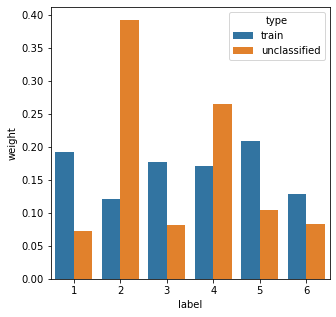

In [12]:
train_lda_df = pd.DataFrame(wt_train)
unclassified_lda_df = pd.DataFrame(wt_unclassified)

train_lda_df.rename(columns={0:"weight"}, inplace = True)
unclassified_lda_df.rename(columns={0:"weight"}, inplace = True)

train_lda_df['type'] = "train"
unclassified_lda_df['type'] = 'unclassified'
train_lda_df['label'] = list(np.arange(1,6+1))
unclassified_lda_df['label'] = list(np.arange(1,6+1))

g1 = pd.concat([train_lda_df, unclassified_lda_df], axis = 0)

fig, ax = plt.subplots(figsize = (5, 5))
sns.barplot(x = 'label', y="weight", data = g1, ax = ax, hue ='type')

In [13]:
#save a graph of lda in directory
train_lda_graph = pyLDAvis.sklearn.prepare(modelLDA, x_train_counts, count_vect)
pyLDAvis.save_html(train_lda_graph, 'lda.html')

c:\Users\jxk8080\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\jxk8080\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [14]:
#we save our topic distribution in to the topic column of train and unclassified data
train_df["topic"] = np.argmax(res, axis = 1)
unclassified_df["topic"] = np.argmax(unclassifiedres, axis = 1)

#we use below counter to balance the training data similarly to the unclassfied data
sample = Counter(unclassified_df["topic"])
print(sample)

Counter({1: 13215, 3: 8090, 4: 2250, 5: 1226, 0: 1150, 2: 1105})


In [15]:
#using make_imbalance we downsample the train data from above counter so it is more similar to the unclassified data.
#the sampling strategy is from our unclassified data lda topic distribution
X_res, y_res = make_imbalance(train_df[["material_group_description","cat_lvl_3_text"]], train_df['topic'],
                              sampling_strategy=sample,
                              random_state=42)

In [16]:
#since we removed some words with resamspling, we fit a new count vectorizer
x_train_topic = count_vect.fit_transform(X_res["material_group_description"])
x_unclassified_topic = count_vect.transform(description_list_unclassified)



#train val split
train_x, val_x, train_y, val_y = train_test_split(x_train_topic, X_res["cat_lvl_3_text"], test_size=0.3)



#converting target classes to numbers
le = LabelEncoder()
le.fit(X_res['cat_lvl_3_text'])
train_y = le.transform(train_y)
val_y = le.transform(val_y)

In [17]:
#multinomial Naive Bayes
mnb = MultinomialNB().fit(train_x, train_y)
pred_y_mnb = mnb.predict(val_x)

In [18]:
#metrics
print(classification_report(val_y, pred_y_mnb, zero_division=0))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       106
           1       0.00      0.00      0.00         1
           2       0.46      1.00      0.63        12
           3       1.00      0.60      0.75         5
           4       0.92      1.00      0.96       504
           5       0.97      0.99      0.98      1500
           6       0.93      0.74      0.82       269
           7       0.00      0.00      0.00         3
           9       0.89      0.97      0.93        40
          10       0.00      0.00      0.00         4
          11       1.00      0.20      0.33        15
          12       0.87      1.00      0.93        67
          13       0.99      1.00      0.99        93
          14       0.97      0.84      0.90        43
          15       0.99      0.99      0.99      5254
          17       1.00      1.00      1.00         8
          18       0.93      0.93      0.93       150
          19       1.00    

In [19]:
#random forest
clf = RandomForestClassifier( random_state=42)
depth = [50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65]

param_grid = {
    "n_estimators": [1000],
    'max_depth': depth, 
    }
param_grid = list(ParameterGrid(param_grid))

train_scores = []
val_scores = []
for param in param_grid:
    clf.set_params(**param)
    clf.fit(X=train_x, y=train_y)
    pred_y_rf = clf.predict(val_x)
    val_scores.append(f1_score(val_y, pred_y_rf, average ='macro'))

    train_scores.append(f1_score(train_y,clf.predict(train_x),average='macro'))

<AxesSubplot:xlabel='depth', ylabel='f1'>

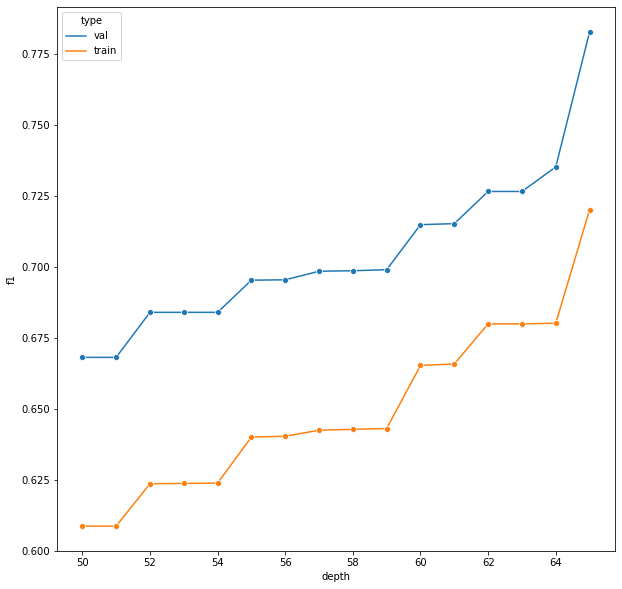

In [20]:
#appending list to df to graph it in seaborn
temp1 = pd.DataFrame(val_scores)
temp1['type'] = 'val'
temp1['depth'] = depth
temp2 = pd.DataFrame(train_scores)
temp2['type'] = 'train'
temp2['depth'] = depth

acc = pd.concat([temp1, temp2], ignore_index=True )
acc.rename(columns = {0: "f1"}, inplace = True)

fig, ax = plt.subplots(figsize = (10, 10))
sns.lineplot(y = "f1", x = 'depth',data = acc, ax = ax, hue = "type", marker = 'o')

In [21]:
xgb_model = xgb.XGBClassifier(objective="multi:softmax", random_state=42, early_stopping = True)

param_grid = {
    "n_estimators": [10000],
    'max_depth': [2,3,5,10], 
    'eta': [0.3]
    }
param_grid = list(ParameterGrid(param_grid))

scores_xg = []
for param in param_grid:
    xgb_model.set_params(**param)

    xgb_model.fit(X=train_x, y=train_y,
    eval_set = [(train_x, train_y),(val_x, val_y)],
    early_stopping_rounds = 100
    )
    pred_y_xg = xgb_model.predict(val_x)
    scores_xg.append(f1_score(val_y, pred_y_xg, average ='macro'))

[15:29:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "early_stopping" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.08719	validation_1-mlogloss:1.06863
[1]	validation_0-mlogloss:0.77565	validation_1-mlogloss:0.76351


c:\Users\jxk8080\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-mlogloss:0.61888	validation_1-mlogloss:0.61217
[3]	validation_0-mlogloss:0.51947	validation_1-mlogloss:0.51425
[4]	validation_0-mlogloss:0.44980	validation_1-mlogloss:0.44230
[5]	validation_0-mlogloss:0.39510	validation_1-mlogloss:0.39182
[6]	validation_0-mlogloss:0.35542	validation_1-mlogloss:0.35183
[7]	validation_0-mlogloss:0.32448	validation_1-mlogloss:0.32048
[8]	validation_0-mlogloss:0.29969	validation_1-mlogloss:0.29591
[9]	validation_0-mlogloss:0.27980	validation_1-mlogloss:0.27646
[10]	validation_0-mlogloss:0.26388	validation_1-mlogloss:0.26045
[11]	validation_0-mlogloss:0.25056	validation_1-mlogloss:0.24732
[12]	validation_0-mlogloss:0.23930	validation_1-mlogloss:0.23599
[13]	validation_0-mlogloss:0.22944	validation_1-mlogloss:0.22642
[14]	validation_0-mlogloss:0.22122	validation_1-mlogloss:0.21778
[15]	validation_0-mlogloss:0.21408	validation_1-mlogloss:0.21078
[16]	validation_0-mlogloss:0.20770	validation_1-mlogloss:0.20502
[17]	validation_0-mlogloss:0.2020

c:\Users\jxk8080\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-mlogloss:0.54941	validation_1-mlogloss:0.54631
[3]	validation_0-mlogloss:0.45926	validation_1-mlogloss:0.45643
[4]	validation_0-mlogloss:0.39190	validation_1-mlogloss:0.38844
[5]	validation_0-mlogloss:0.34374	validation_1-mlogloss:0.34065
[6]	validation_0-mlogloss:0.30793	validation_1-mlogloss:0.30475
[7]	validation_0-mlogloss:0.27960	validation_1-mlogloss:0.27700
[8]	validation_0-mlogloss:0.25589	validation_1-mlogloss:0.25200
[9]	validation_0-mlogloss:0.23607	validation_1-mlogloss:0.23207
[10]	validation_0-mlogloss:0.22077	validation_1-mlogloss:0.21677
[11]	validation_0-mlogloss:0.20855	validation_1-mlogloss:0.20464
[12]	validation_0-mlogloss:0.19809	validation_1-mlogloss:0.19498
[13]	validation_0-mlogloss:0.18928	validation_1-mlogloss:0.18563
[14]	validation_0-mlogloss:0.18166	validation_1-mlogloss:0.17862
[15]	validation_0-mlogloss:0.17487	validation_1-mlogloss:0.17275
[16]	validation_0-mlogloss:0.16909	validation_1-mlogloss:0.16746
[17]	validation_0-mlogloss:0.1640

c:\Users\jxk8080\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:0.58810	validation_1-mlogloss:0.58409
[2]	validation_0-mlogloss:0.47839	validation_1-mlogloss:0.47487
[3]	validation_0-mlogloss:0.40043	validation_1-mlogloss:0.39578
[4]	validation_0-mlogloss:0.34307	validation_1-mlogloss:0.33876
[5]	validation_0-mlogloss:0.29795	validation_1-mlogloss:0.29341
[6]	validation_0-mlogloss:0.26408	validation_1-mlogloss:0.25968
[7]	validation_0-mlogloss:0.23775	validation_1-mlogloss:0.23386
[8]	validation_0-mlogloss:0.21669	validation_1-mlogloss:0.21250
[9]	validation_0-mlogloss:0.19950	validation_1-mlogloss:0.19598
[10]	validation_0-mlogloss:0.18404	validation_1-mlogloss:0.18070
[11]	validation_0-mlogloss:0.17251	validation_1-mlogloss:0.16932
[12]	validation_0-mlogloss:0.16253	validation_1-mlogloss:0.16012
[13]	validation_0-mlogloss:0.15389	validation_1-mlogloss:0.15225
[14]	validation_0-mlogloss:0.14680	validation_1-mlogloss:0.14536
[15]	validation_0-mlogloss:0.13993	validation_1-mlogloss:0.13936
[16]	validation_0-mlogloss:0.13441

c:\Users\jxk8080\Anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-mlogloss:0.51607	validation_1-mlogloss:0.51028
[2]	validation_0-mlogloss:0.41335	validation_1-mlogloss:0.40774
[3]	validation_0-mlogloss:0.33964	validation_1-mlogloss:0.33478
[4]	validation_0-mlogloss:0.28469	validation_1-mlogloss:0.28008
[5]	validation_0-mlogloss:0.24310	validation_1-mlogloss:0.23896
[6]	validation_0-mlogloss:0.21130	validation_1-mlogloss:0.20809
[7]	validation_0-mlogloss:0.18651	validation_1-mlogloss:0.18367
[8]	validation_0-mlogloss:0.16749	validation_1-mlogloss:0.16592
[9]	validation_0-mlogloss:0.15212	validation_1-mlogloss:0.15109
[10]	validation_0-mlogloss:0.13951	validation_1-mlogloss:0.13962
[11]	validation_0-mlogloss:0.12917	validation_1-mlogloss:0.13012
[12]	validation_0-mlogloss:0.12119	validation_1-mlogloss:0.12265
[13]	validation_0-mlogloss:0.11437	validation_1-mlogloss:0.11631
[14]	validation_0-mlogloss:0.10906	validation_1-mlogloss:0.11146
[15]	validation_0-mlogloss:0.10328	validation_1-mlogloss:0.10633
[16]	validation_0-mlogloss:0.09869

In [22]:
scores_xg

[0.7730002977685055, 0.7971102409737464, 0.797413006960354, 0.7935745863813901]

In [23]:
## if wanting to apply model on unclassified
le.inverse_transform(pred_y_xg)
final_output = xgb_model.predict(x_unclassified_topic)
unclassified_df["predicted"] = le.inverse_transform(final_output)

In [24]:
unclassified_df

,material_group_description,material_description,cat_lvl_3_text,topic,predicted
88,lab/technical equip,Aluminum Sample Testing,UNCLASSIFIED,4,MRO
89,lab/technical equip,Aluminum Sample Testing 020 Trial,UNCLASSIFIED,4,MRO
103,office supplies,"10(L) x 10(W) x 10(H) Shipping Boxes, B",UNCLASSIFIED,1,MRO
104,office supplies,12 1/4 x 9 1/4 x 12'' Multi Depth Shi,UNCLASSIFIED,1,MRO
105,office supplies,12(L) x 12(W) x 12(H) Deluxe Moving Box,UNCLASSIFIED,1,MRO
...,...,...,...,...,...
257005,"xdel: mach & eq, oth",for temp streachwrap loaner freight,UNCLASSIFIED,2,EQUIPMENT
257007,"xdel: prod supp, oth",WATER TREATMENT 2020,UNCLASSIFIED,3,MRO
257008,xdel: r&d material,Nordson Display,UNCLASSIFIED,5,MRO
257009,xdel: repair service r&d,LIFT EQUIPMENT,UNCLASSIFIED,3,FACILITIES


In [25]:
# output the df to excel file in out_files
unclassified_df.to_excel(f'./out_files/categorized_lvl_3.xlsx', 
                 index=False)